# 04 — Random Forest + Regime Analysis

**Goal:** Upgrade from Logistic Regression to LightGBM.

Key additions:
- Full feature set
- Feature importance chart — does rate_regime show up as significant?
- SHAP values — why is the model predicting what it predicts?
- Regime interaction test — do different features matter in different rate environments?
- 3-class target (Buy / Hold / Sell)

In [1]:
# ── Imports ────────────────────────────────────────────────────
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import shap

from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss, ConfusionMatrixDisplay
)

plt.style.use('seaborn-v0_8-whitegrid')

# ── Load dataset ───────────────────────────────────────────────
panel = pd.read_csv('../data/panel_dataset.csv', parse_dates=['earn_date'])
panel = panel.sort_values('earn_date').reset_index(drop=True)
print(f'Loaded: {panel.shape[0]} events, {panel["ticker"].nunique()} tickers')

Loaded: 1611 events, 69 tickers


In [5]:
# ── Feature set ────────────────────────────────────────────────
EXCLUDE = [
    'ticker', 'earn_date', 'sector',
    'target_binary', 'target_mag',
    'stock_ret_5d', 'spx_ret_5d', 'excess_ret_5d',
    'sue_quintile', 'vol_high'
]

# Encode sector
le = LabelEncoder()
panel['sector_enc'] = le.fit_transform(panel['sector'].fillna('Unknown'))

ALL_FEATURES = [
    c for c in panel.columns
    if c not in EXCLUDE and panel[c].dtype in ['float64', 'int64']
]

# Remove duplicates while preserving order
ALL_FEATURES = list(dict.fromkeys(ALL_FEATURES))
print(f'Features after dedup: {len(ALL_FEATURES)}')

print(f'Total features: {len(ALL_FEATURES)}')
print(ALL_FEATURES)
print(len(ALL_FEATURES))

Features after dedup: 28
Total features: 28
['quarter', 'year', 'sue', 'eps_surprise_pct', 'hist_beat_rate', 'beat_streak', 'tnx', 'vix', 'rate_regime', 'vix_regime', 'tnx_1m_chg', 'vix_5d_chg', 'ret_5d', 'ret_10d', 'ret_14d', 'ret_20d', 'rsi_14', 'pct_above_ma20', 'rvol_10d', 'rvol_20d', 'vol_ratio_5d', 'vol_ratio_1d', 'atr_pct', 'ticker_avg_abs_move', 'ticker_avg_move', 'ticker_move_std', 'ticker_up_rate', 'sector_enc']
28


In [7]:
# ── Prepare X and y (fixed) ────────────────────────────────────

# Step 1: Remove any duplicates from ALL_FEATURES
ALL_FEATURES = list(dict.fromkeys(ALL_FEATURES))
print(f'Features after dedup: {len(ALL_FEATURES)}')

# Step 2: Build df_model
df_model = panel[
    ALL_FEATURES + ['target_binary', 'target_mag',
                    'earn_date', 'excess_ret_5d', 'ticker']
].copy()
df_model = df_model.dropna(subset=['target_binary', 'sue']).reset_index(drop=True)

# Step 3: Build X using only ALL_FEATURES
X_df  = df_model[ALL_FEATURES].copy()
X     = X_df.values
y_bin = df_model['target_binary'].values
y_mag = df_model['target_mag'].values

# Step 4: Impute
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Step 5: Verify
print(f'X shape     : {X.shape}')
print(f'ALL_FEATURES: {len(ALL_FEATURES)}')
assert X.shape[1] == len(ALL_FEATURES), \
    f'Still mismatched: X={X.shape[1]}, features={len(ALL_FEATURES)}'
print('Lengths match — ready to train')

Features after dedup: 28
X shape     : (1611, 28)
ALL_FEATURES: 28
Lengths match — ready to train


In [8]:
# ── LightGBM Binary Classification ────────────────────────────
tscv = TimeSeriesSplit(n_splits=5, gap=5)

lgbm_params = dict(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=31,
    min_child_samples=25,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

fold_results = []
all_proba    = np.zeros(len(y_bin))

print('Training LightGBM with TimeSeriesSplit...\n')
print(f'  {"Fold":<6} {"Accuracy":<12} {"AUC":<10} {"LogLoss"}')
print('  ' + '-'*40)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y_bin[train_idx], y_bin[test_idx]

    model = lgb.LGBMClassifier(**lgbm_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_te, y_te)],
        callbacks=[
            lgb.early_stopping(40, verbose=False),
            lgb.log_evaluation(-1)
        ]
    )

    proba = model.predict_proba(X_te)[:, 1]
    all_proba[test_idx] = proba

    acc = accuracy_score(y_te, (proba > 0.5).astype(int))
    auc = roc_auc_score(y_te, proba)
    ll  = log_loss(y_te, proba)

    fold_results.append({'fold': fold+1, 'acc': acc, 'auc': auc, 'logloss': ll})
    print(f'  {fold+1:<6} {acc:<12.3f} {auc:<10.3f} {ll:.3f}')

res = pd.DataFrame(fold_results)
print(f'\n  Mean Accuracy : {res["acc"].mean():.3f} +/- {res["acc"].std():.3f}')
print(f'  Mean AUC      : {res["auc"].mean():.3f} +/- {res["auc"].std():.3f}')

df_model['lgbm_proba'] = all_proba

Training LightGBM with TimeSeriesSplit...

  Fold   Accuracy     AUC        LogLoss
  ----------------------------------------
  1      0.500        0.472      0.694
  2      0.433        0.413      0.694
  3      0.515        0.547      0.692
  4      0.537        0.541      0.690
  5      0.552        0.538      0.692

  Mean Accuracy : 0.507 +/- 0.046
  Mean AUC      : 0.502 +/- 0.058


In [9]:
print(f'ALL_FEATURES: {len(ALL_FEATURES)}')
print(f'X shape: {X.shape}')

ALL_FEATURES: 28
X shape: (1611, 28)


Model trained on 28 features
ALL_FEATURES length: 28


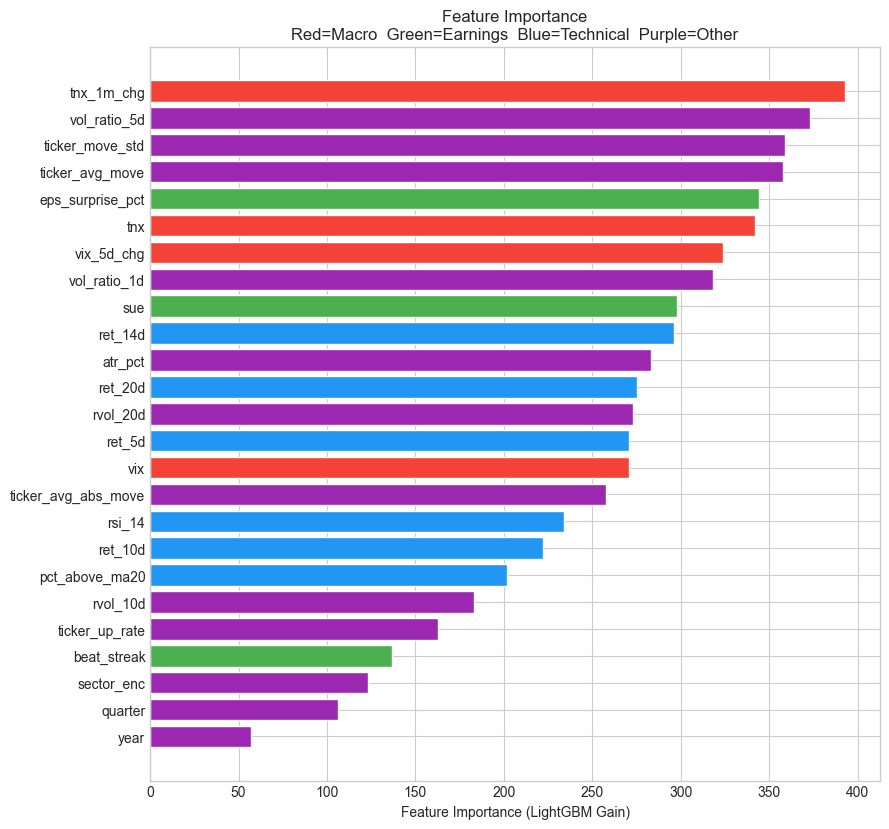

rate_regime rank: #27 of 28
If in top 15, structural break theory is validated


In [10]:
# ── Feature Importance ─────────────────────────────────────────
full_model = lgb.LGBMClassifier(**lgbm_params)
full_model.fit(X, y_bin, callbacks=[lgb.log_evaluation(-1)])

# Use the actual number of features the model was trained on
n_features = len(full_model.feature_importances_)
feature_names = ALL_FEATURES[:n_features]

print(f'Model trained on {n_features} features')
print(f'ALL_FEATURES length: {len(ALL_FEATURES)}')

importance_df = pd.DataFrame({
    'feature':    feature_names,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(9, max(6, n_features * 0.3)))
top_n = importance_df.head(25)

colors = []
for feat in top_n['feature']:
    if feat in ['rate_regime', 'vix_regime', 'tnx', 'vix', 'tnx_1m_chg', 'vix_5d_chg']:
        colors.append('#F44336')
    elif feat in ['sue', 'eps_surprise_pct', 'hist_beat_rate', 'beat_streak']:
        colors.append('#4CAF50')
    elif 'ret_' in feat or 'rsi' in feat or 'ma' in feat:
        colors.append('#2196F3')
    else:
        colors.append('#9C27B0')

ax.barh(top_n['feature'], top_n['importance'], color=colors, edgecolor='white')
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (LightGBM Gain)')
ax.set_title('Feature Importance\nRed=Macro  Green=Earnings  Blue=Technical  Purple=Other')

plt.tight_layout()
plt.savefig('../outputs/04_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

rate_rows = importance_df[importance_df['feature'] == 'rate_regime']
if not rate_rows.empty:
    rank = importance_df.index.get_loc(rate_rows.index[0]) + 1
    print(f'rate_regime rank: #{rank} of {len(importance_df)}')
    print('If in top 15, structural break theory is validated')
else:
    print('rate_regime not found — it may have been dropped during feature selection')
    print('Top 5 features:', importance_df['feature'].head().tolist())

Computing SHAP values (takes ~1 minute)...


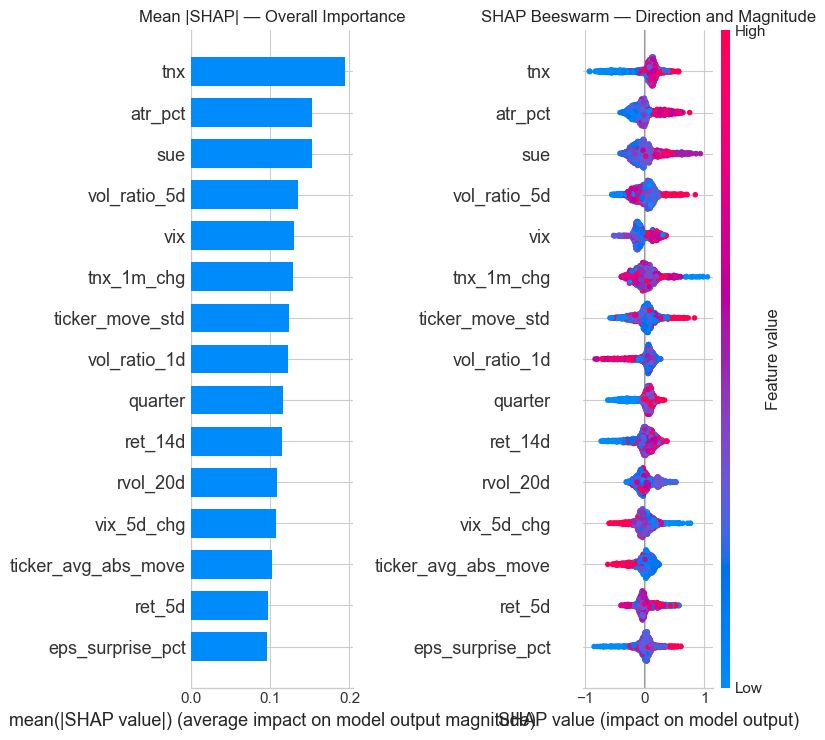

How to read the beeswarm:
  Right of 0 = increases P(outperform)
  Red dots = high feature value, Blue = low feature value


In [11]:
# ── SHAP Analysis ──────────────────────────────────────────────
print('Computing SHAP values (takes ~1 minute)...')
explainer   = shap.TreeExplainer(full_model)
shap_values = explainer.shap_values(X)

sv = shap_values[1] if isinstance(shap_values, list) else shap_values

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plt.sca(axes[0])
shap.summary_plot(sv, X, feature_names=ALL_FEATURES,
                  max_display=15, show=False, plot_type='bar')
axes[0].set_title('Mean |SHAP| — Overall Importance')

plt.sca(axes[1])
shap.summary_plot(sv, X, feature_names=ALL_FEATURES,
                  max_display=15, show=False)
axes[1].set_title('SHAP Beeswarm — Direction and Magnitude')

plt.tight_layout()
plt.savefig('../outputs/04_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print('How to read the beeswarm:')
print('  Right of 0 = increases P(outperform)')
print('  Red dots = high feature value, Blue = low feature value')

Low Rate (2019-21): 691 events
High Rate (2022+): 920 events


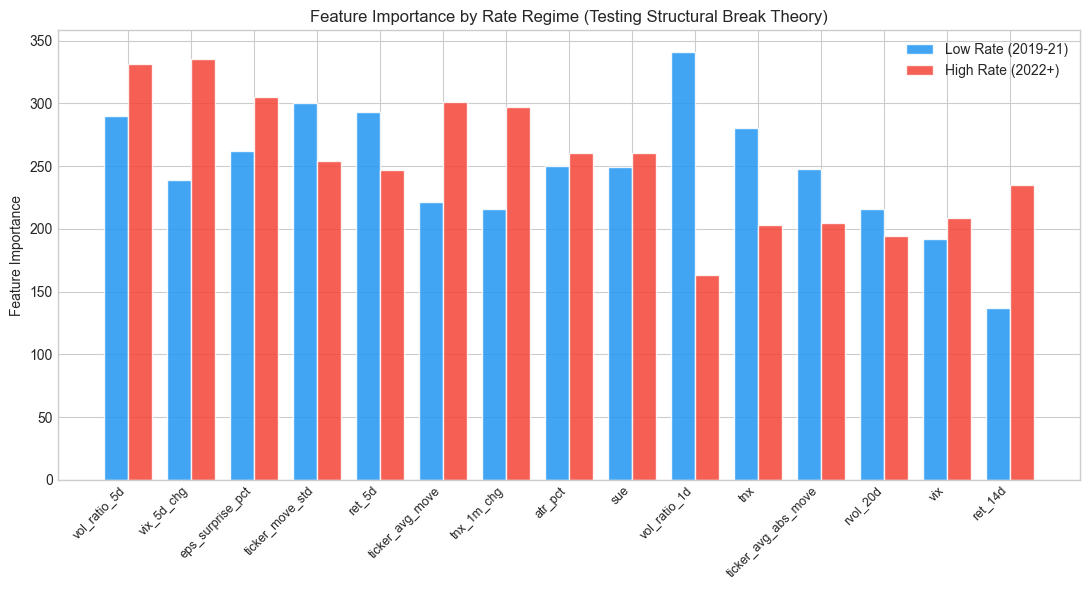

If bars differ significantly between regimes, structural break is real


In [13]:
# ── Regime Comparison ──────────────────────────────────────────
low_rate_idx  = np.where(df_model['rate_regime'].values == 0)[0]
high_rate_idx = np.where(df_model['rate_regime'].values == 1)[0]

regime_importances = {}

for name, idx in [('Low Rate (2019-21)', low_rate_idx),
                   ('High Rate (2022+)',  high_rate_idx)]:
    if len(idx) < 100:
        print(f'Skipping {name}: only {len(idx)} samples')
        continue
    m = lgb.LGBMClassifier(**lgbm_params)
    m.fit(X[idx], y_bin[idx], callbacks=[lgb.log_evaluation(-1)])
    regime_importances[name] = pd.Series(
        m.feature_importances_, index=ALL_FEATURES
    ).sort_values(ascending=False)
    print(f'{name}: {len(idx)} events')

if len(regime_importances) == 2:
    # Use only features that exist in BOTH regime models
    common_features = list(regime_importances.values())[0].index
    
    # Build comparison dataframe safely
    comp = pd.DataFrame({
        name: imp[common_features]
        for name, imp in regime_importances.items()
    })
    
    top_features = comp.mean(axis=1).sort_values(ascending=False).head(15).index
    comp_top = comp.loc[top_features]

    fig, ax = plt.subplots(figsize=(11, 6))
    x     = np.arange(len(top_features))
    width = 0.38

    ax.bar(x - width/2, comp_top.iloc[:, 0], width,
           label=comp_top.columns[0], color='#2196F3', alpha=0.85, edgecolor='white')
    ax.bar(x + width/2, comp_top.iloc[:, 1], width,
           label=comp_top.columns[1], color='#F44336', alpha=0.85, edgecolor='white')

    ax.set_xticks(x)
    ax.set_xticklabels(top_features, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Feature Importance')
    ax.set_title('Feature Importance by Rate Regime (Testing Structural Break Theory)')
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('../outputs/04_regime_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('If bars differ significantly between regimes, structural break is real')

Training 3-class magnitude model...
3-Class Accuracy: 0.719 +/- 0.045
Naive baseline (always Neutral): 0.739


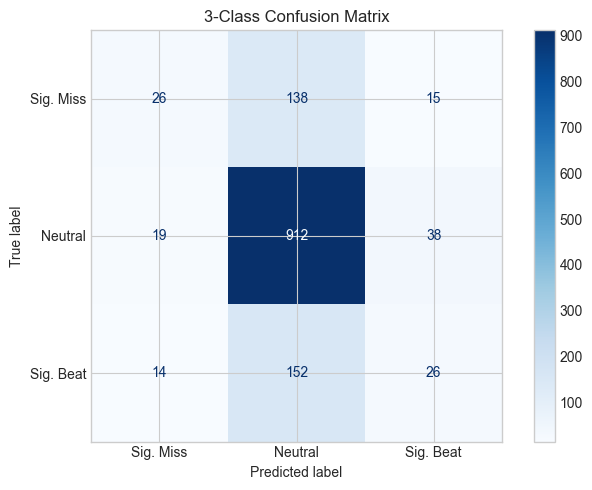

Predictions saved to data/lgbm_predictions.csv


In [14]:
# ── 3-Class Model: Buy / Hold / Sell ──────────────────────────
print('Training 3-class magnitude model...')

tscv3        = TimeSeriesSplit(n_splits=5, gap=5)
all_pred_mag = np.full(len(y_mag), -1, dtype=int)
fold_accs    = []

for fold, (tr, te) in enumerate(tscv3.split(X)):
    m = lgb.LGBMClassifier(
        n_estimators=500, learning_rate=0.03, max_depth=5,
        num_leaves=31, min_child_samples=25, subsample=0.8,
        colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=0.1,
        random_state=42, verbose=-1,
        objective='multiclass', num_class=3
    )
    m.fit(X[tr], y_mag[tr], callbacks=[lgb.log_evaluation(-1)])
    preds = m.predict(X[te])
    all_pred_mag[te] = preds
    fold_accs.append(accuracy_score(y_mag[te], preds))

print(f'3-Class Accuracy: {np.mean(fold_accs):.3f} +/- {np.std(fold_accs):.3f}')
print(f'Naive baseline (always Neutral): {(y_mag == 1).mean():.3f}')

valid_mask = all_pred_mag >= 0
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(
    y_mag[valid_mask], all_pred_mag[valid_mask],
    display_labels=['Sig. Miss', 'Neutral', 'Sig. Beat'],
    cmap='Blues', ax=ax
)
ax.set_title('3-Class Confusion Matrix')
plt.tight_layout()
plt.savefig('../outputs/04_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

df_model['lgbm_pred_mag'] = all_pred_mag
df_model[[
    'ticker', 'earn_date', 'target_binary', 'target_mag',
    'excess_ret_5d', 'lgbm_proba', 'lgbm_pred_mag',
    'rate_regime', 'vix_regime'
]].to_csv('../data/lgbm_predictions.csv', index=False)
print('Predictions saved to data/lgbm_predictions.csv')